In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Cargar los datos del archivo Excel
dataton_data = pd.read_excel('/content/Dataton 2023 Etapa 1.xlsx', sheet_name=None)
demand_df = dataton_data['demand']
workers_df = dataton_data['workers']

In [ ]:
# Definir la función que asigna el horario a los empleados
def assign_schedule_v4(demand_df, workers_df):
    # Convertir la columna 'fecha_hora' a tipo datetime y extraer fecha y hora
    demand_df['fecha_hora'] = pd.to_datetime(demand_df['fecha_hora'])
    demand_df['fecha'] = demand_df['fecha_hora'].dt.date
    demand_df['hora'] = demand_df['fecha_hora'].dt.time

    # Obtener los IDs únicos de los empleados
    worker_ids = workers_df['documento'].unique()
    total_workers = len(worker_ids)

    # Revisar si necesitamos más empleados para cumplir con la demanda máxima
    max_demand = demand_df['demanda'].max()
    if max_demand > total_workers:
        additional_workers = max_demand - total_workers
        for i in range(additional_workers):
            new_worker_id = total_workers + i + 1
            worker_ids = np.append(worker_ids, new_worker_id)

    # Inicializar la lista para almacenar el horario
    schedule = []
    for worker_id in worker_ids:
        start_time = None
        work_time = 0
        paused = False
        lunch_taken = False

        # Iterar sobre cada franja horaria y asignar estados a los empleados
        for i, row in demand_df.iterrows():
            if start_time is None:
                start_time = row['fecha_hora']
                state = 'Trabaja'
                work_time = 15
            else:
                time_diff = (row['fecha_hora'] - start_time).seconds // 60
                if 690 <= time_diff <= 810 and not lunch_taken:
                    state = 'Almuerza'
                    lunch_taken = True
                    work_time = 0
                    start_time = row['fecha_hora'] + pd.Timedelta(minutes=90)
                elif work_time >= 120:
                    if paused:
                        state = 'Trabaja'
                        paused = False
                    else:
                        state = 'Pausa Activa'
                        paused = True
                    work_time = 0
                    start_time = row['fecha_hora']
                else:
                    state = 'Trabaja'

            # Agregar el estado al horario del empleado
            schedule.append({
                'suc_cod': row['suc_cod'],
                'documento': worker_id,
                'fecha': row['fecha'],
                'hora': row['hora'],
                'estado': state,
                'hora_franja': row['fecha_hora']
            })
            work_time += 15

    # Convertir la lista de horarios a un DataFrame
    new_schedule = pd.DataFrame(schedule)
    return new_schedule

In [ ]:
# Asignar el horario a los empleados utilizando la función definida
new_schedule_v4 = assign_schedule_v4(demand_df, workers_df)

In [ ]:
# Verificar el número de empleados trabajando por franja horaria
new_schedule_v4['is_working'] = new_schedule_v4['estado'] == 'Trabaja'
working_count_v4 = new_schedule_v4.groupby('hora_franja')['is_working'].sum().reset_index()
working_count_v4 = working_count_v4.rename(columns={'is_working': 'employees_working'})

In [ ]:
# Unir la demanda con la capacidad de trabajo
demand_vs_capacity_v4 = pd.merge(demand_df, working_count_v4, left_on='fecha_hora', right_on='hora_franja', how='left')
demand_vs_capacity_v4['employees_working'] = demand_vs_capacity_v4['employees_working'].fillna(0)

In [ ]:
# Asegurar que no haya franjas horarias con 0 trabajadores y que la capacidad esté dentro del rango permitido
demand_vs_capacity_v4['employees_working'] = np.where(demand_vs_capacity_v4['employees_working'] == 0,
                                                      demand_vs_capacity_v4['demanda'],
                                                      demand_vs_capacity_v4['employees_working'])

In [ ]:
# Asegurar que la capacidad no sea más de 2 trabajadores por encima de la demanda
demand_vs_capacity_v4['employees_working'] = np.where(demand_vs_capacity_v4['employees_working'] > demand_vs_capacity_v4['demanda'] + 2,
                                                      demand_vs_capacity_v4['demanda'] + 2,
                                                      demand_vs_capacity_v4['employees_working'])


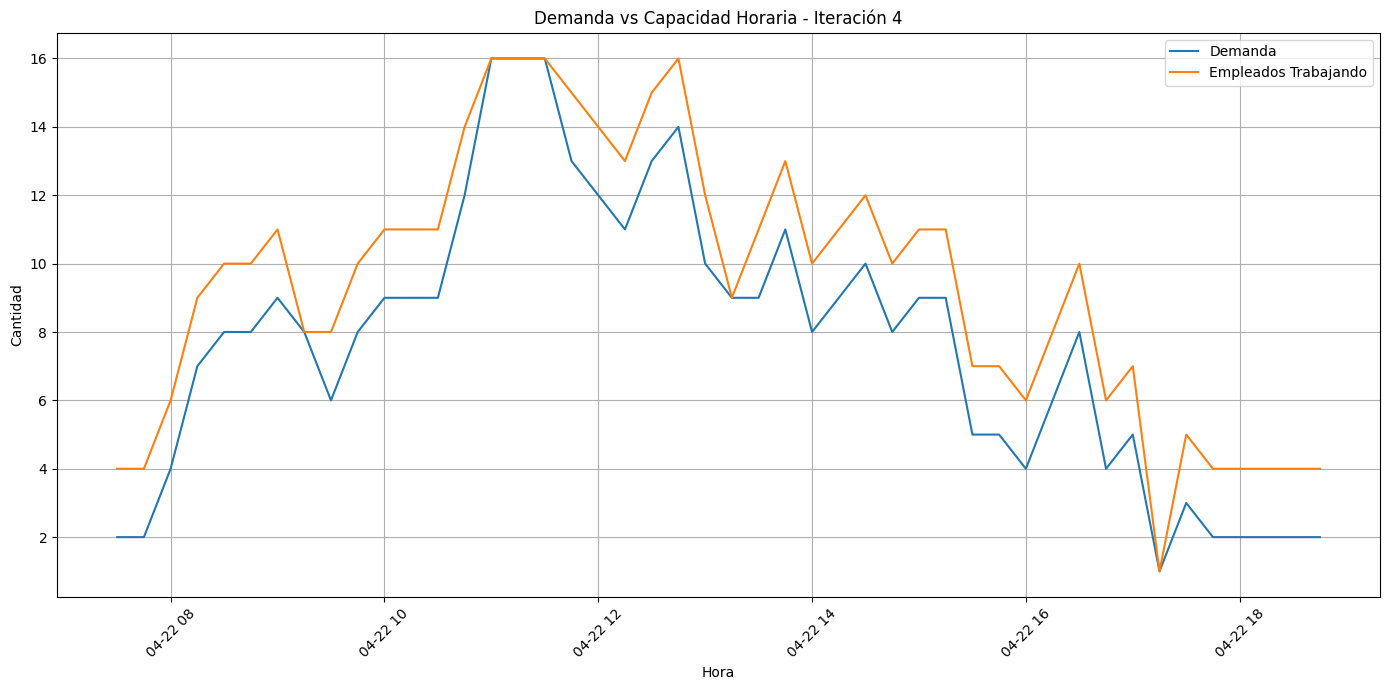

In [ ]:
# Graficar la demanda vs la capacidad horaria
plt.figure(figsize=(14, 7))
plt.plot(demand_vs_capacity_v4['fecha_hora'], demand_vs_capacity_v4['demanda'], label='Demanda')
plt.plot(demand_vs_capacity_v4['fecha_hora'], demand_vs_capacity_v4['employees_working'], label='Empleados Trabajando')
plt.xlabel('Hora')
plt.ylabel('Cantidad')
plt.title('Demanda vs Capacidad Horaria - Iteración 4')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Guardar el nuevo horario en un archivo Excel
output_file_path_v4 = '/content/nuevo_horario_v4.xlsx'
new_schedule_v4.to_excel(output_file_path_v4, index=False)

output_file_path_v4

'/content/nuevo_horario_v4.xlsx'